# Template for analyzing the CLM5-PPE
- Updated July 8, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm

## spin up some extra cores on CASPER

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
#only run once
cluster, client = get_ClusterClient()
cluster.scale(20)

In [4]:
#note that you should eventually see your workers in the output here
# you can rerun this cell, to check that the job made it through the queue
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:40251,Workers: 0
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Total threads: 0
Started: Just now,Total memory: 0 B


## A few useful functions

In [5]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def param_effect(da,p,uniques,cf):
    nyrs=10

    x0      = (cf*month_wts(nyrs)*la*da).compute()
    x1      = 1/nyrs*x0.sum(dim='time').compute()
    
    mean    = x1.sum(dim='gridcell').compute()
    iav     = x0.sum(dim='gridcell').groupby('time.year').sum().std(dim='year').compute()
    xdefs   = np.array([mean.sel(ens=0).values,iav.sel(ens=0).values])

    
    effect_on_mean =[]
    effect_on_iav  =[]
    dxs            =[]
    for param in uniques:
        print(param)
        ix    = p==param
        xvals = x1.isel(ens=ix)
        mean2 = mean.isel(ens=ix)
        iav2  = iav.isel(ens=ix)
        
        if len(mean2)==2:
            #has min and max
            effect_on_mean.append(abs(mean2[0]-mean2[1]).values)
            effect_on_iav.append(abs(iav2[0]-iav2[1]).values)
            dxs.append(xvals[:,0]-xvals[:,1])
        else:
            #only has one or the other, sub in default x[0]
            effect_on_mean.append(abs(mean[0]-mean2[0]).values)
            effect_on_iav.append(abs(iav[0]-iav2[0]).values)
            dxs.append(x1.sel(ens=0)-xvals[:,0])

    dx      = xr.concat(dxs,dim='ens')
    r2      = np.corrcoef(dx)**2
    r2[np.isnan(r2)]=1   #this is to correct for BFBs
    spatial = r2.sum(axis=0)
            
    effect_on_mean = np.array(effect_on_mean)
    effect_on_iav  = np.array(effect_on_iav)

    return effect_on_mean,effect_on_iav,spatial,xdefs

In [8]:
def get_map(da):
    '''
    Regrid from sparsegrid to standard lat/lon
    
    Better to do any dimension-reducing math before calling this function. 
    Could otherwise be pretty slow...
    '''
    
    #ACCESS the sparsegrid info
    thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
    thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
    sg = xr.open_dataset(thedir+thefile)
    
    #DIAGNOSE the shape of the output map
    newshape = []
    coords=[]
    #  grab any dimensions that arent "gridcell" from da
    for coord,nx in zip(da.coords,da.shape):
        if nx!=400:
            newshape.append(nx)
            coords.append((coord,da[coord]))
    #  grab lat/lon from sg
    for coord in ['lat','lon']:
        nx = len(sg[coord])
        newshape.append(nx)
        coords.append((coord,sg[coord]))

    #INSTANTIATE the outgoing array
    array = np.zeros(newshape)+np.nan
    nd    = len(array.shape)
    
    #FILL the array
    ds = xr.open_dataset('/glade/scratch/djk2120/PPEn11/hist/CTL2010/PPEn11_CTL2010_OAAT0399.clm2.h0.2005-02-01-00000.nc')
    for i in range(400):
        lat=ds.grid1d_lat[i]
        lon=ds.grid1d_lon[i]
        cc = sg.rcent.sel(lat=lat,lon=lon,method='nearest')
        ix = sg.cclass==cc
        
        
        if nd==2:
            array[ix]=da.isel(gridcell=i)
        else:
            nx = ix.sum().values
            array[:,ix]=np.tile(da.isel(gridcell=i).values[:,np.newaxis],[1,nx])
    
    #OUTPUT as DataArray
    da_map = xr.DataArray(array,name=da.name,coords=coords)
    da_map.attrs=da.attrs

    return da_map

In [9]:
def get_ensemble(name,data_vars,htape,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = sorted(glob.glob(thisdir+'*'+htape+'*'))

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',parallel=True,preprocess=preprocess)

    #fix up time dimension
    ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    keys           = [file.split('_')[2].split('.')[0] for file in files]
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

In [10]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/jul22.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

FileNotFoundError: [Errno 2] No such file or directory: '/glade/scratch/djk2120/PPEn11/jul22.csv'

## START HERE:

In [13]:
name = 'C285'
data_vars = ['GPP','HR','AR']
htape = 'h0'
ds = get_ensemble(name,data_vars,htape,paramkey)

In [14]:
ds.GPP

<xarray.DataArray 'GPP' (ens: 394, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(394, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: ens, gridcell
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [67]:
#use the landarea vector and month_wts to calculate average annual GPP
cf = 24*60*60*1e-9  #PgC
gpp_glob     = (la*ds.GPP).sum(dim='gridcell')
gpp_glob_ann = cf*(month_wts(10)*gpp_glob).groupby('time.year').sum()
gpp_avg      = gpp_glob_ann.mean(dim='year').compute()

In [64]:
print(ds.param)

<xarray.DataArray 'param' (ens: 394)>
array(['default', 'taulnir', 'taulnir', 'taulvis', 'taulvis', 'tausnir',
       'tausnir', 'tausvis', 'tausvis', 'rholnir', 'rholnir', 'rholvis',
       'rholvis', 'rhosnir', 'rhosnir', 'rhosvis', 'rhosvis', 'xl', 'xl',
       'displar', 'displar', 'dleaf', 'dleaf', 'z0mr', 'z0mr', 'csoilc',
       'csoilc', 'cv', 'cv', 'a_coef', 'a_exp', 'zlnd', 'zlnd', 'zsno',
       'zsno', 'd_max', 'd_max', 'frac_sat_soil_dsl_init',
       'frac_sat_soil_dsl_init', 'lai_dl', 'z_dl', 'z_dl',
       'zetamaxstable', 'zetamaxstable', 'wind_min', 'wind_min',
       'tkd_sand', 'tkd_sand', 'tkd_clay', 'tkd_clay', 'tkd_om', 'tkd_om',
       'tkm_om', 'tkm_om', 'pd', 'pd', 'csol_om', 'csol_om', 'csol_sand',
       'csol_sand', 'csol_clay', 'csol_clay', 'bsw_sf', 'bsw_sf',
       'hksat_sf', 'hksat_sf', 'sucsat_sf', 'sucsat_sf', 'watsat_sf',
       'watsat_sf', 'baseflow_scalar', 'baseflow_scalar',
       'maximum_leaf_wetted_fraction', 'maximum_leaf_wetted_fraction',


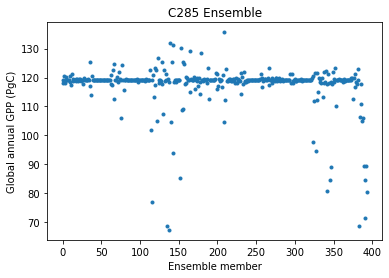

In [46]:
gpp_avg.plot.line('.')
plt.xlabel('Ensemble member')
plt.ylabel('Global annual GPP (PgC)')
plt.title('C285 Ensemble');

In [63]:
#which perturbations yield the bottom 10 lowest GPP?
print('LOW GPP:')
for i in np.argsort(gpp_avg)[:10]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print(gpp_avg[i].values,'   '+p+'-'+m)
  
print('HIGH GPP:')
for i in np.argsort(gpp_avg)[-10:]:
    p = str(ds.param[i].values)
    m = str(ds.minmax[i].values)
    print(gpp_avg[i].values,'   '+p+'-'+m)


LOW GPP:
67.27804612632569    jmaxb0-min
68.49807602762466    lmrse-max
68.71937186191334    lmrse-max2
71.3587497626432    lmrhd-min2
76.90239594230866    medlynintercept-max
80.41571576121396    medlynintercept-max2
80.75879727993342    lmrhd-min
84.67348426905178    vcmaxse_sf-max
84.69857312200594    vcmaxse_sf-max2
85.23908380627184    kmax-min
HIGH GPP:
125.30049362004763    jmaxb1-max
125.39002258625051    krmax-max
125.51758788213006    d_max-max
126.63108142893802    theta_cj-max
128.42397115765678    FUN_fracfixers-max
129.15899844720403    nstem-max
130.07412201802003    kmax-max
131.09859484706527    wc2wjb0-max
131.8676627013919    jmaxb0-max
135.67432831220626    leafcn-min


### look at the map of jmaxb0-min

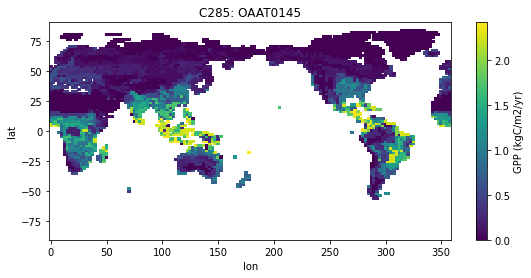

In [71]:
#find the given member
ix  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='min')
da  = ds.GPP.isel(ens=ix) 

#calc annual gpp
nyrs = 10
cf   = 24*60*60/nyrs/1000
gpp  = cf*(month_wts(nyrs)*da).sum(dim='time').compute() #kgC/m2/yr

#convert to map
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot(cbar_kwargs={'label':'GPP (kgC/m2/yr)'})
plt.title('C285: '+str(ds.key.isel(ens=ix).values[0]));

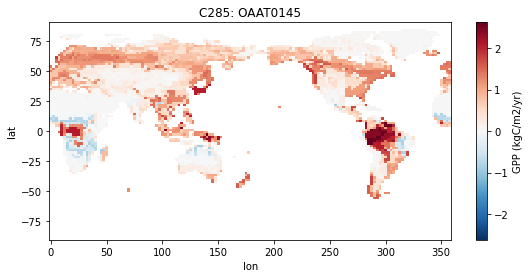

In [66]:
#find the given member
ix1  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='min')
ix2  = np.logical_and(ds.param=='jmaxb0',ds.minmax=='max')
da  = ds.GPP.isel(ens=ix2) - ds.GPP.isel(ens=ix1)

#calc annual gpp
nyrs = 10
cf   = 24*60*60/nyrs/1000
gpp  = cf*(month_wts(nyrs)*da).sum(dim='time').compute() #kgC/m2/yr

#convert to map
gpp_map = get_map(gpp)

#plot
plt.figure(figsize=[9,4])
gpp_map.plot(cbar_kwargs={'label':'GPP (kgC/m2/yr)'})
plt.title('C285: '+str(ds.key.isel(ens=ix).values[0]));

### calculate parameter effect
- i.e. max perturb -  min perturb

In [77]:
cf = 24*60*60*1e-9 #PgC
da = ds.GPP
uniques = ['kmax','krmax','psi50','ck']
mean,iav,spatial,xdefs=param_effect(da,ds.param,uniques,cf)

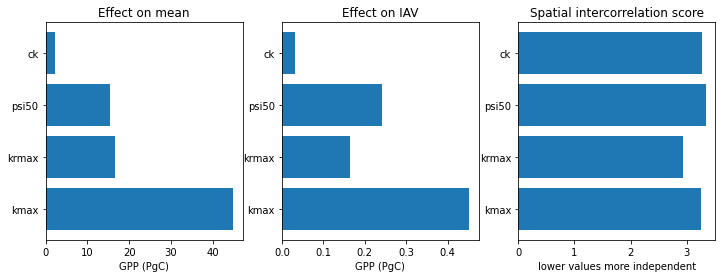

In [90]:
plt.figure(figsize=[12,4])
plt.subplot(131)
plt.barh(range(4),mean)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on mean');

plt.subplot(132)
plt.barh(range(4),iav)
plt.yticks(range(4),uniques)
plt.xlabel('GPP (PgC)')
plt.title('Effect on IAV');

plt.subplot(133)
plt.barh(range(4),spatial)
plt.yticks(range(4),uniques)
plt.xlabel('lower values more independent')
plt.title('Spatial intercorrelation score');